# Simple GP Regression on EEG data

## Imports

In [1]:
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

import msc

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Load data

picks: ('C3',)
Reading header...
Reading 0 ... 103935  =      0.000 ...   405.996 secs...
Filtering raw data in 1 contiguous segment

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Filter length: 1 samples (0.004 sec)



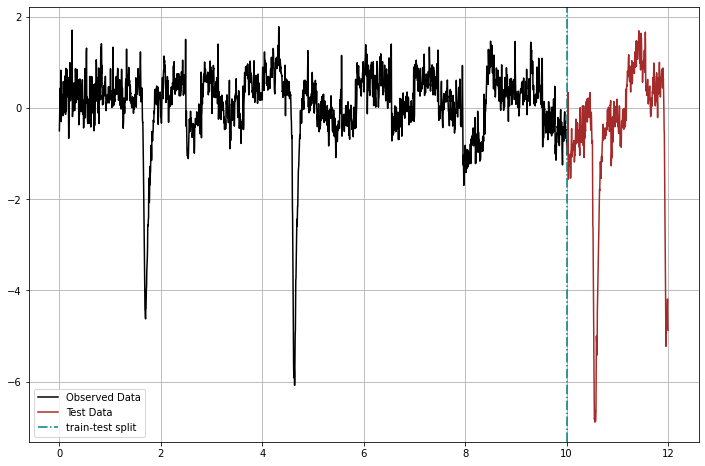

In [2]:
picks = msc.etl.PicksOptions.one_channel
dataset = msc.etl.load_tensor_dataset(picks=picks)
train_x = dataset.get("train_x")
train_y = dataset.get("train_y")
test_x = dataset.get("test_x")
test_y = dataset.get("test_y")


# train_y = np.exp(train_y)
# test_y = np.exp(test_y)
# plot training data
# Initialize plot
(f, ax), ymin, ymax = plt.subplots(1, 1, figsize=(12, 8)), -5e-4, 5e-4

ax.plot(train_x.numpy(), train_y.numpy(), 'black', label='Observed Data')
ax.plot(test_x.numpy(), test_y.numpy(), 'brown', label='Test Data')
ax.axvline(10, label='train-test split', color='teal', linestyle='-.')
ax.grid('both')
# ax.set_ylim([ymin, ymax])
ax.legend()

## Initialize likelihood and model

In [3]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)


## Train

In [4]:
# this is for running the notebook in our testing framework
import os

smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print(f"Iter {i+1}/{training_iter} - Loss: {loss.item()}  lengthscale: {model.covar_module.base_kernel.lengthscale.item()}")
    optimizer.step()


C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\gpytorch\utils\linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ..\aten\src\ATen\native\Resize.cpp:23.)
  torch.sum(mul_storage, -2, keepdim=True, out=alpha)


Iter 1/50 - Loss: 1.1075409650802612  lengthscale: 0.6931471824645996
Iter 2/50 - Loss: 1.0885695219039917  lengthscale: 0.6443967223167419
Iter 3/50 - Loss: 1.066116452217102  lengthscale: 0.598598062992096
Iter 4/50 - Loss: 1.0408660173416138  lengthscale: 0.5554223656654358
Iter 5/50 - Loss: 1.0157586336135864  lengthscale: 0.514359176158905
Iter 6/50 - Loss: 0.9925957918167114  lengthscale: 0.4753625690937042
Iter 7/50 - Loss: 0.9685447812080383  lengthscale: 0.43849122524261475
Iter 8/50 - Loss: 0.9407551288604736  lengthscale: 0.4036693572998047
Iter 9/50 - Loss: 0.9135221838951111  lengthscale: 0.37087181210517883
Iter 10/50 - Loss: 0.8891752362251282  lengthscale: 0.34010520577430725
Iter 11/50 - Loss: 0.8589469790458679  lengthscale: 0.3113475739955902
Iter 12/50 - Loss: 0.8257991075515747  lengthscale: 0.2844429314136505
Iter 13/50 - Loss: 0.7954759001731873  lengthscale: 0.2593264579772949
Iter 14/50 - Loss: 0.7585906982421875  lengthscale: 0.23594073951244354
Iter 15/50 - L

C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\gpytorch\utils\linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 7188.39501953125 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 45/50 - Loss: 751.597412109375  lengthscale: 0.008816901594400406


C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\gpytorch\utils\linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 4277.06640625 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 46/50 - Loss: 2180.076171875  lengthscale: 0.00824840646237135


C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\gpytorch\utils\linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 4050.53662109375 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 47/50 - Loss: 206.4407958984375  lengthscale: 0.007687659002840519


C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\gpytorch\utils\linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 14958.015625 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 48/50 - Loss: 155.77488708496094  lengthscale: 0.007206518203020096


C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\gpytorch\utils\linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 4376.25146484375 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 49/50 - Loss: 66.1166000366211  lengthscale: 0.006790245417505503
Iter 50/50 - Loss: 76.0688705444336  lengthscale: 0.006431807763874531


C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\gpytorch\utils\linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 6437.42236328125 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


## Test

In [5]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # test_x = torch.linspace(0, 12, 151)
    observed_pred = likelihood(model(train_x))

C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\gpytorch\models\exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\gpytorch\utils\linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1237.1927490234375 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


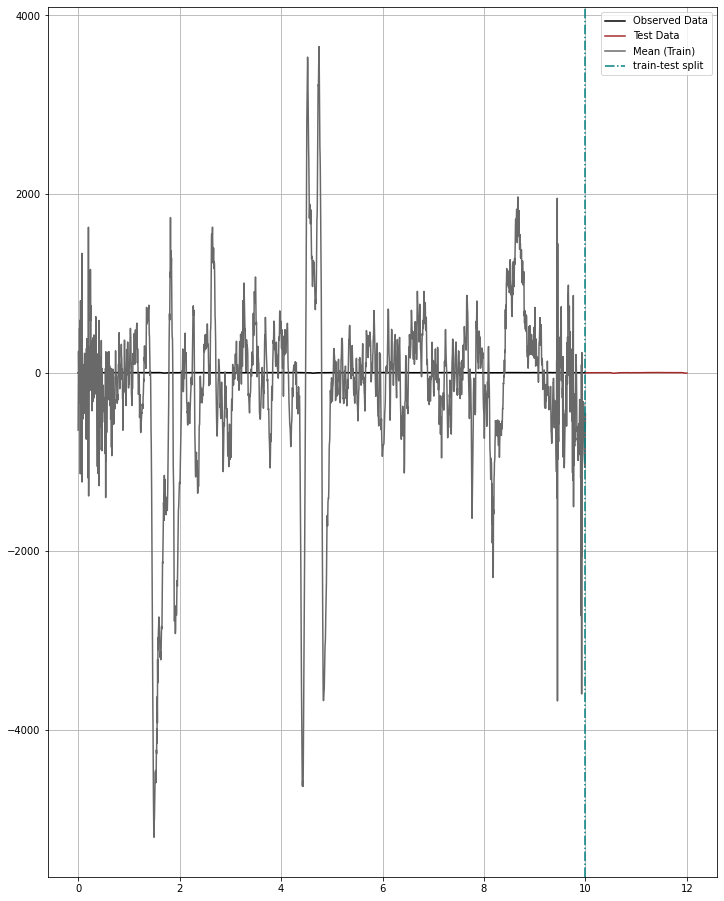

In [6]:
with torch.no_grad():
    # ####### PLOT WITH Y LIMITS #######
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(12, 16))
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    split_ix = len(train_x)
    train_lower, test_lower, train_upper, test_upper = lower[:split_ix], lower[split_ix:], upper[:split_ix], upper[split_ix:]
    # Plot training data
    ax.plot(train_x.numpy(), train_y.numpy(), 'black', label='Observed Data')
    # Plot testing data
    ax.plot(test_x.numpy(), test_y.numpy(), 'brown', label='Test Data')
    # Plot predictive means in train region
    ax.plot(train_x.numpy(), observed_pred[:split_ix].mean.numpy(), 'dimgray', label='Mean (Train)')
    # Plot predictive means in test region
#     ax.plot(test_x.numpy(), observed_pred[split_ix:].mean.numpy(), 'b', label='Mean (Test)')
    # Shade between the lower and upper confidence bounds  (train)
#     ax.fill_between(train_x.numpy(), train_lower.numpy(), train_upper.numpy(), alpha=0.5, label='Confidence (Train)')
    # Shade between the lower and upper confidence bounds  (test)
#     ax.fill_between(test_x.numpy(), test_lower.numpy(), test_upper.numpy(), alpha=0.5, label='Confidence (Test)')
    ax.axvline(10, label='train-test split', color='teal', linestyle='-.')
    ax.grid('both')
    ax.legend()
#     a.set_ylim([ymin, ymax])


In [7]:
# plt.plot(train_lower)